In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
import sys
sys.path.append('..')
from transformers import AutoModelForSequenceClassification
from modeling_rmt import RMTEncoderForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from modeling_rmt import RMTEncoderForSequenceClassification
# from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
num_segments = 3
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'

In [4]:
model_name = 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': num_mem_tokens, 
                'max_n_segments': num_segments,
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
                'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

# base_model1 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt1 = RMTEncoderForSequenceClassification(base_model1, **rmt_config)

# base_model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt2 = RMTEncoderForSequenceClassification(base_model2, **rmt_config)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).cpu()
rmt = RMTEncoderForSequenceClassification(base_model, **rmt_config).cpu()

# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt = RMTEncoderHorizontalMemory(base_model, **rmt_config)
# rmt.to(device)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from 

In [5]:
# cpt = torch.load('../../runs/curriculum_task/babilong_random_v2/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_998-512-{3}seg_mem10_bs32_iters3000_regular_from_cpt_1-2/run_1/model_best.pth', map_location=device)
cpt = torch.load('../../runs/curriculum_task/babilong_random_v2/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_1497-512-{3}seg_mem10_bs32_iters3000_regular_from_cpt_2-3/run_1/model_best.pth', map_location=device)

In [6]:
rmt.load_state_dict(cpt['model_state_dict'])
# rmt1.load_state_dict(cpt1['model_state_dict'])
# rmt2.load_state_dict(cpt2['model_state_dict'])

<All keys matched successfully>

In [7]:
# out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
# out.keys()

### load dataset 

In [15]:
class Holder:
    def __init__(self):
        pass

In [16]:
input_seq_len = 1497
target_seq_len = 512
batch_size = 1

args = Holder
args.num_mem_tokens = 10
args.max_n_segments = 3
args.input_size = 512
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [17]:
from datasets import load_dataset
names = ['Mary', 'John', 'Daniel', 'Sandra']
actions = ['moved', 'went', 'went back', 'journeyed', 'travelled']
places = ['bathroom', 'hallway', 'garden', 'office', 'bedroom', 'kitchen']
choices_dict = {'names': names, 'actions': actions, 'places': places}

class MemoryDataset(Dataset):
    def __init__(self, choices_dict=choices_dict, num_facts=1, split='train', dataset='quality', num_samples=None):
        self.choices_dict = choices_dict
        self.dataset = load_dataset('tau/scrolls', dataset)[split]
        self.num_facts = num_facts
        self.num_samples = num_samples

    def __getitem__(self, ind):
        if self.num_samples:
            ind = np.random.randint(len(self.dataset))
        sample = self.dataset[ind]
        sample['fact'], sample['question'], sample['answer'] = self.generate_qa() 
        return sample
    
    def __len__(self):
        return len(self.dataset) if self.num_samples is None else self.num_samples

    def generate_qa(self):
        names, actions, places = self.choices_dict['names'], self.choices_dict['actions'], self.choices_dict['places']

        np.random.shuffle(names)
        facts, questions, answers = [], [], []
        for fact_num, name in zip(range(self.num_facts), names):
            action, place = np.random.choice(actions), np.random.choice(places)

            facts.append(f'{name} {action} to the {place}')
            questions.append(f'Where is {name}?')
            answers.append(place)

        facts = ', '.join(facts) + '.'
        questions = ' '.join(questions)
        answers = ', '.join(answers)
        
        return facts, questions, answers

In [19]:
train_dataset = MemoryDataset(choices_dict, num_facts=1, split='train', dataset='quality')
valid_dataset = MemoryDataset(choices_dict, num_facts=1, split='validation', dataset='quality', num_samples=1000)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

### enc-dec

In [20]:
# # raise NotImplementedError
# global_attention_first_token = False  # should be True for LED
# encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# # generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
# generate_kwargs = {}

# def collate_fn(batch):
#     # cut too long strings because they may slow down tokenization
#     inputs = [b['fact'] + b['input'][:args.input_seq_len * 10] for b in batch]
#     questions = [b['question'] for b in batch]
#     labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
#     if args.input_prefix:
#         inputs = [args.input_prefix + inp for inp in inputs]

#     max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
#     features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=max_length)
#     questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
#                                                 **encode_plus_kwargs).input_ids
#     labels[labels == tokenizer.pad_token_id] = -100
#     features['labels'] = labels
#     features['id'] = [b['id'] for b in batch]
#     features['target_text'] = [b['answer'] for b in batch]
#     if 'global_attention_mask' in features:
#         raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
#     return features


### enc

In [23]:
answers = train_dataset.choices_dict['places']
labels_map = dict(zip(answers, range(len(answers))))
num_labels = len(labels_map)
if args.num_mem_tokens is None:
    input_seg_size = args.input_size
else:
    input_seg_size = args.input_size - args.num_mem_tokens - tokenizer.num_special_tokens_to_add()
    if 'sep_token' in tokenizer.special_tokens_map:
        input_seg_size -= 1

encode_plus_kwargs = {
                    #   'max_length': args.input_seq_len,
                        'truncation': True,
                        'padding': 'longest',
                        'pad_to_multiple_of': 1}
generate_kwargs = {}


In [42]:

fact_segment = 1
# random_position = False
# if hasattr(args, 'fact_segment'):
#     fact_segment = args.fact_segment
# if hasattr(args, 'random_position'):
#     random_position = args.random_position

def collate_fn(batch, input_seg_size=input_seg_size, fact_segment=fact_segment, random_position=random_position):
    facts = [b['fact'] for b in batch]
    inputs = [' '.join([b['input']]) * int(np.ceil(args.input_seq_len * 10 / len(b['input']))) for b in batch]
    questions = [b['question'] for b in batch]
    labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]

    total_input_size = args.max_n_segments * input_seg_size
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=total_input_size)
    questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

    if random_position:
        fact_start_positions = np.random.randint(0, args.max_n_segments, len(batch)) * input_seg_size + 1
    else:
        fact_start_positions = np.ones(len(batch), dtype=int) * fact_segment * input_seg_size + 1

    for i, position in enumerate(fact_start_positions):
        fact = tokenizer.encode(facts[i], return_tensors='pt', add_special_tokens=False)[0]
        features['input_ids'][i, position:position + len(fact)] = fact

    q_len = questions.shape[1] - 1
    max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
    features['input_ids'] = torch.cat([features['input_ids'][:, :max_length - q_len], questions[:, 1:]], dim=1)
    
    labels = np.array([labels_map[t] for t in labels])
    features['labels'] = torch.from_numpy(labels)
    return features

In [43]:
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=True,
#                                        drop_last=False, seed=args.seed)
# per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
# global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': 1}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,# sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)
# # get validation dataset
# valid_dataloader = None
# if hvd.rank() == 0:
#     logger.info(f'preparing validation data from babilong')
# # if args.task_name in tasks_with_duplicates:
# #     valid_dataset = drop_duplicates_in_input(valid_dataset)
# valid_sampler = DistributedSampler(valid_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=per_worker_batch_size, sampler=valid_sampler,
#                                 collate_fn=collate_fn, **kwargs)

In [44]:
gen = iter(train_dataloader)
batch = next(gen)


In [45]:
input_ids = batch.pop('input_ids')
out = rmt(input_ids, **batch, output_attentions = True)
# out1 = rmt1(input_ids, **batch, output_attentions = True)
# out2 = rmt2(input_ids, **batch, output_attentions = True)

In [46]:
out.loss

tensor(0.0380, grad_fn=<NllLossBackward>)

In [47]:
[(key, out[key]) for key in out if 'loss' in key]

[('loss', tensor(0.0380, grad_fn=<NllLossBackward>)),
 ('loss_0', tensor(0.9353, grad_fn=<NllLossBackward>)),
 ('loss_1', tensor(0.0153, grad_fn=<NllLossBackward>)),
 ('loss_2', tensor(0.0380, grad_fn=<NllLossBackward>))]

In [50]:
tokenizer.decode(input_ids[0][499:])

'd Mary went back to the hallway. over. It was better to retire on a limited crediting, on a confoundedly limited crediting, than to take the two or three more trips in hopes of attaining a higher standard. He\'d had plenty of time to figure it out, there alone in space on the Moon run, there on the Venus or Mars runs. There on the long, long haul to the Jupiter satellites, fearfully checking the symptoms of space cafard, the madness compounded of claustrophobia, monotony, boredom and free fall. Plenty of time. Time to decide that a one room mini - auto - apartment, complete with an autochair and built - in autobar, and with one wall a teevee screen, was all he needed to find contentment for a mighty long time. Possibly somebody like Doc Girard - Perregaux might be horrified at the idea of living in a mini - auto - apartment... not realizing that to a pilot it was roomy beyond belief compared to the conning tower of a space craft. No. Even as Si listened to their speeches, accepted the

### plot attentions


In [51]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None):
    # attentions n_layers x n_heads x len x len
    attention = attentions.detach()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(sz, sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens)#, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [53]:
segmented = rmt.pad_and_segment(input_ids)

### seg 0: Write to memory

<Figure size 720x720 with 0 Axes>

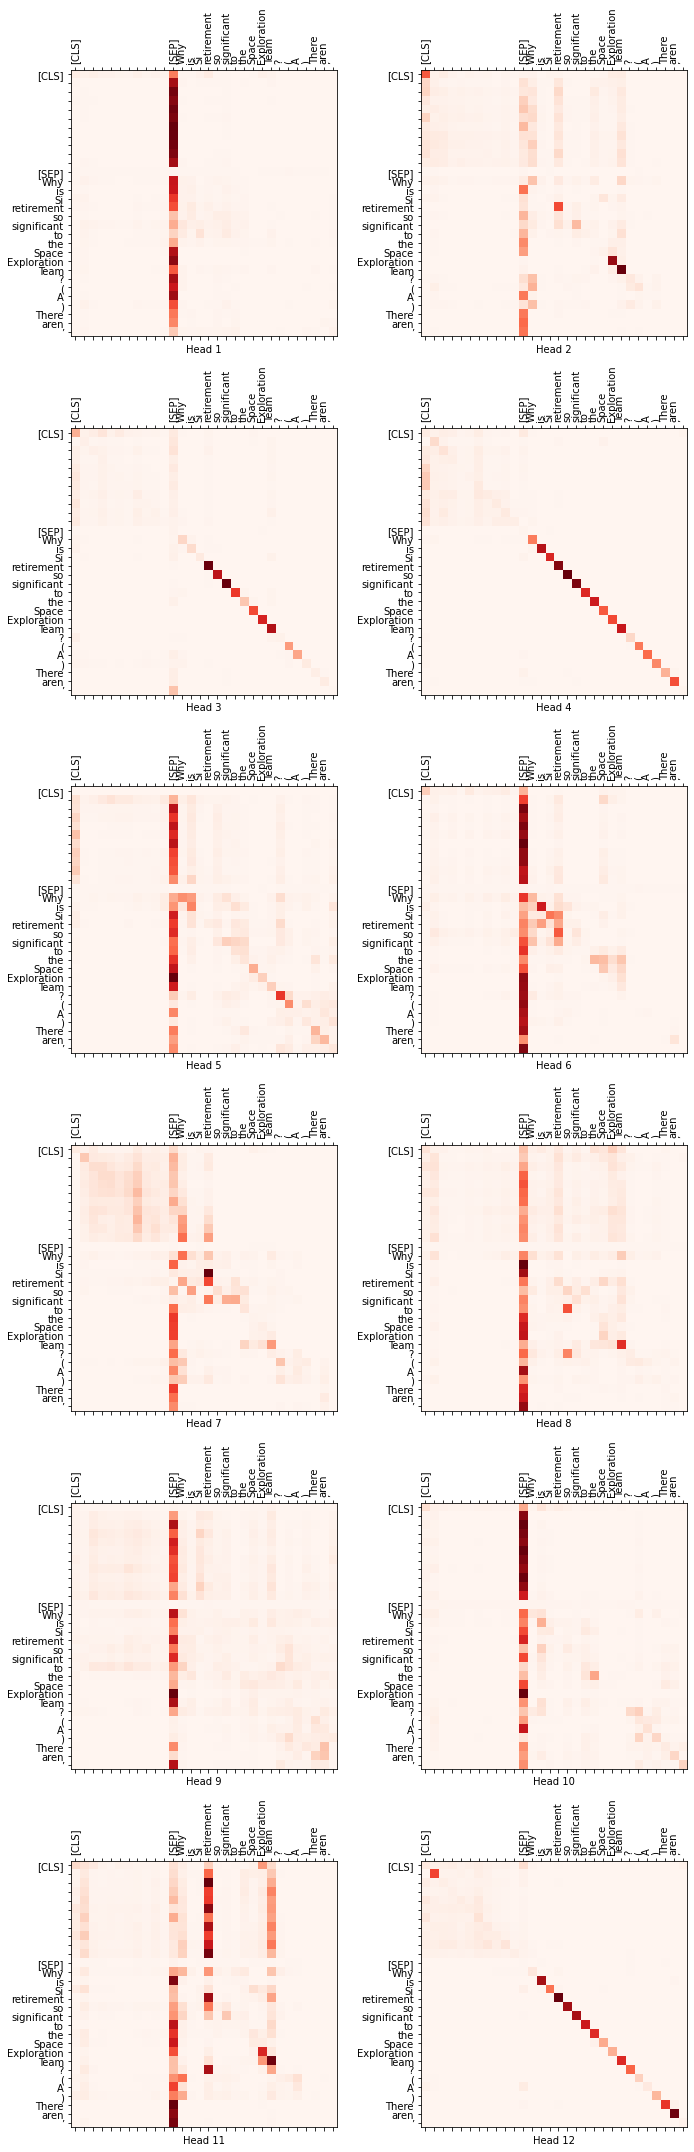

In [54]:
layer = -1
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg1

In [80]:
len(attentions), attentions[0].shape

(12, torch.Size([2, 12, 180, 180]))

In [44]:
head = 0
attentions[layer][bn][head]

torch.Size([12, 180, 180])

<Figure size 720x720 with 0 Axes>

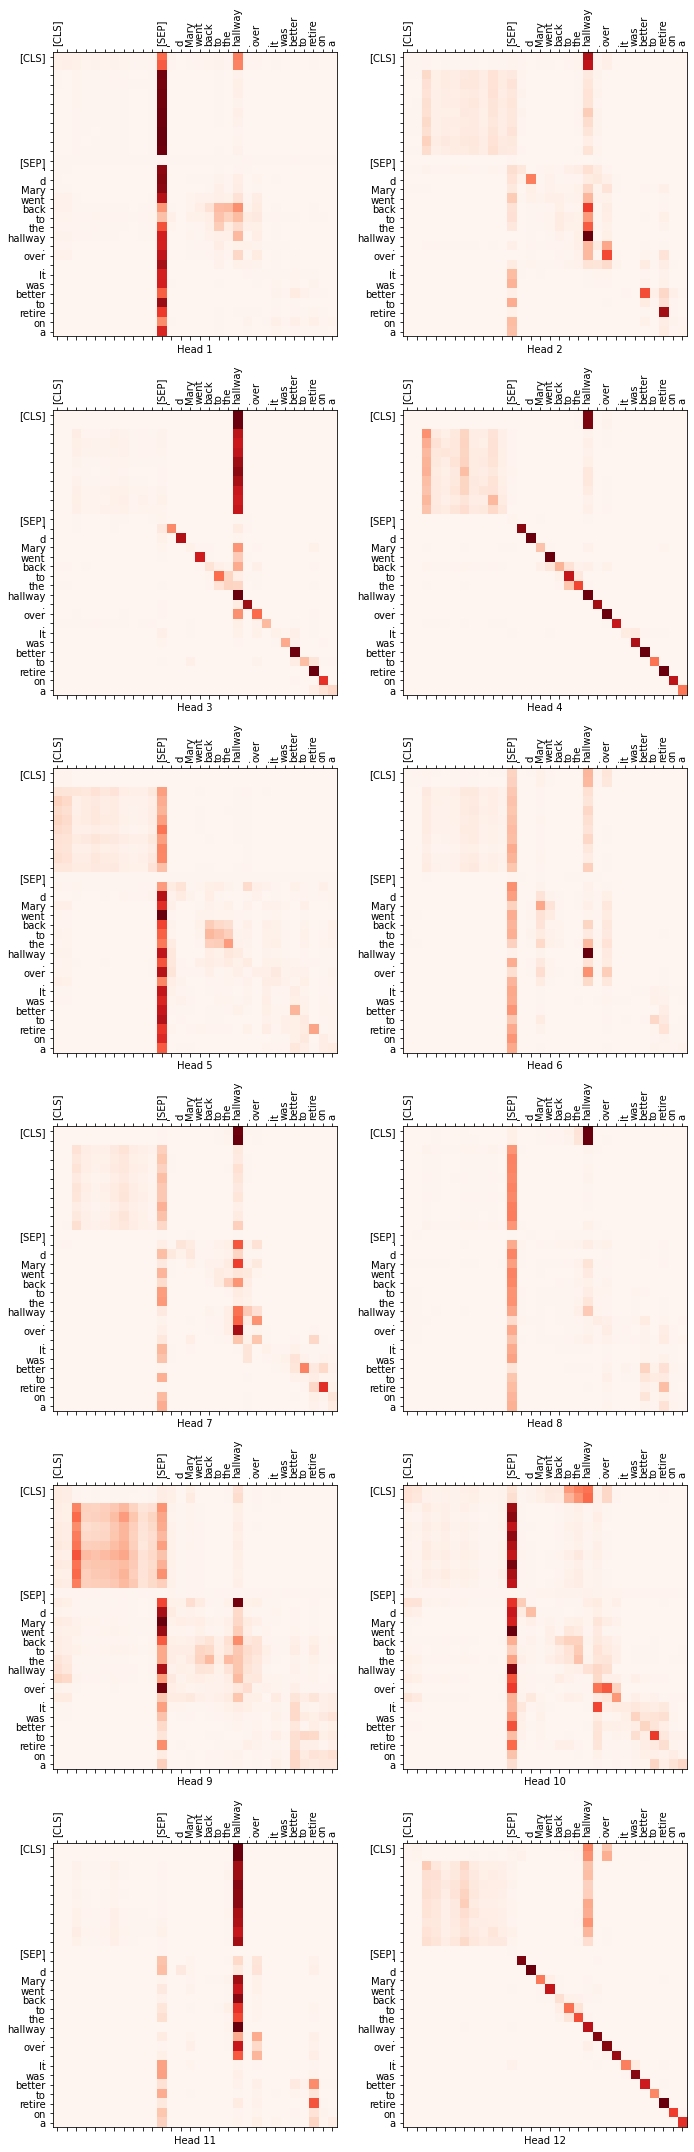

In [55]:
layer = -1
segment = 1
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg2

<Figure size 720x720 with 0 Axes>

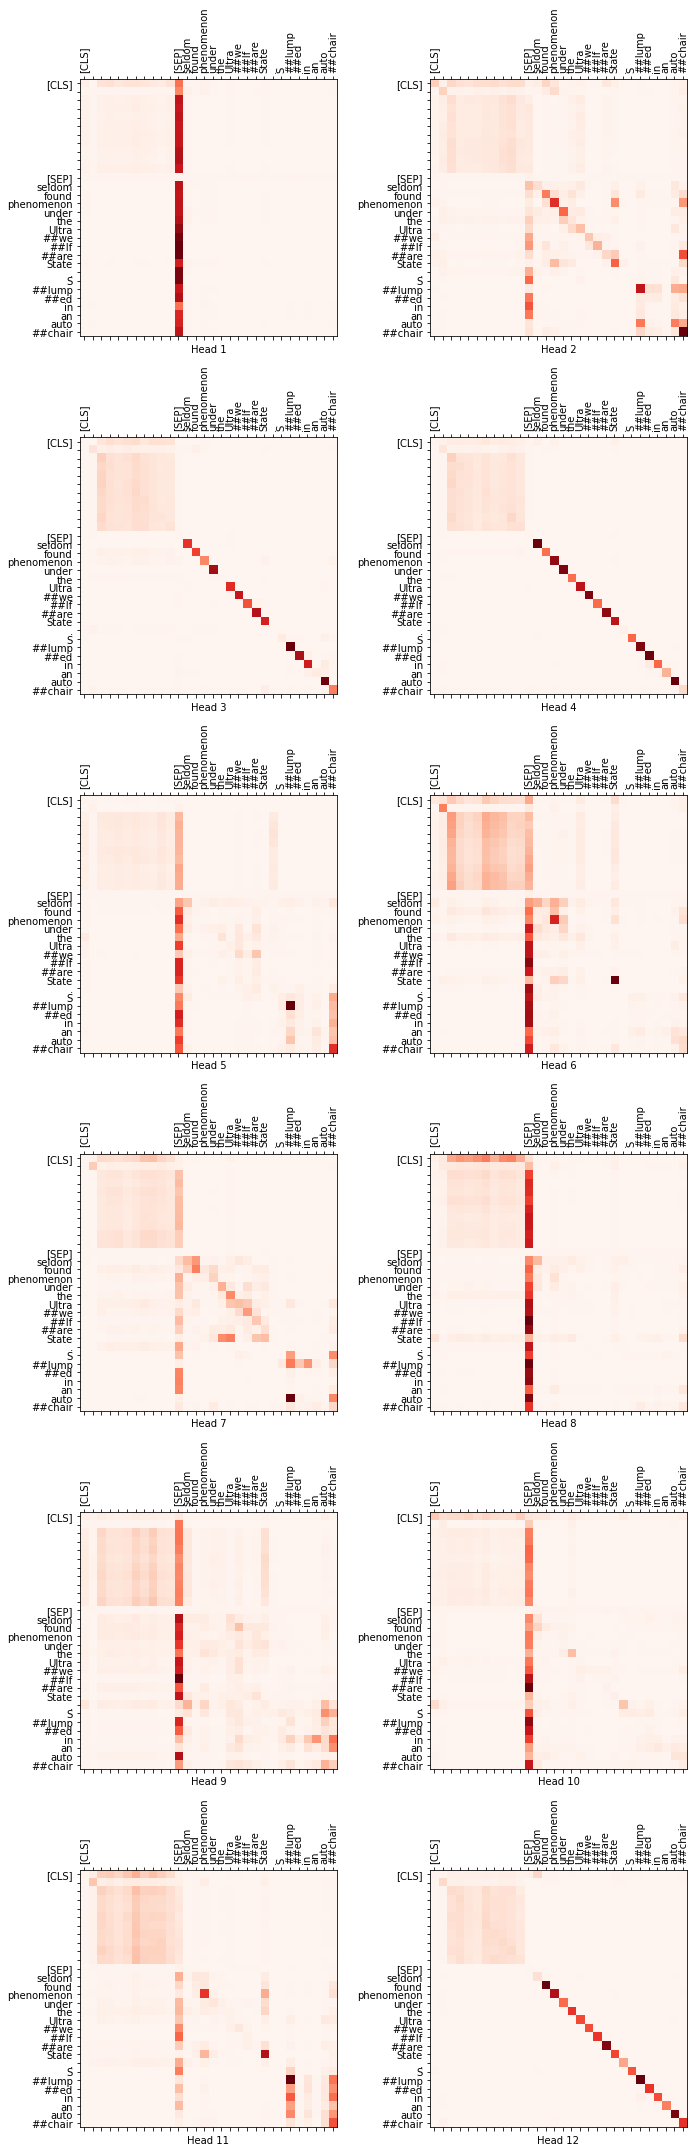

In [57]:
layer = -1
segment = 2
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)